In [1]:
pip install catboost


  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=d94f5fd92aea5828d2631520c77e87290d7a8919aaf3969e5065192c91d9fc30
  Stored in directory: c:\users\d\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [2]:
TRAIN_DATASET_PATH = r'D:\Distr\python\project\train.csv'
TEST_DATASET_PATH = r'D:\Distr\python\project\test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.982,29.443,6.000,7,9.000,1969,0.089,B,B,33,7976,5,NaN,0,11,B,184966.931
15053,41,3.000,65.684,40.050,8.000,7,9.000,1978,0.000,B,B,46,10309,1,240.000,1,16,B,300009.450
4765,53,2.000,44.948,29.198,0.000,8,12.000,1968,0.050,B,B,34,7759,0,229.000,1,3,B,220925.909
5809,58,2.000,53.353,52.732,9.000,8,17.000,1977,0.438,B,B,23,5735,3,1084.000,0,5,B,175616.227
10783,99,1.000,39.649,23.776,7.000,11,12.000,1976,0.012,B,B,35,5776,1,2078.000,2,4,B,150226.532


In [4]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.000,49.883,33.433,6.000,6,14.000,1972,0.310,B,B,11,2748,1,NaN,0,0,B
15856,74,2.000,69.263,NaN,1.000,6,1.000,1977,0.076,B,B,6,1437,3,NaN,0,2,B
5480,190,1.000,13.598,15.948,12.000,2,5.000,1909,0.000,B,B,30,7538,87,4702.000,5,5,B
15664,47,2.000,73.047,51.941,9.000,22,22.000,2007,0.102,B,B,23,4583,3,NaN,3,3,B
14275,27,1.000,47.527,43.388,1.000,17,17.000,2017,0.072,B,B,2,629,1,NaN,0,0,A


In [5]:
train_df.shape, test_df.shape

((10000, 19), (5000, 18))

In [6]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.000,10000.000,7887.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,50.401,1.891,56.316,37.200,6.273,8.527,12.609,3990.166,0.119,24.687,5352.157,8.039,1142.904,1.319,4.231,214138.857
std,43.588,0.840,21.059,86.241,28.561,5.241,6.776,200500.261,0.119,17.533,4006.800,23.832,1021.517,1.494,4.806,92872.294
min,0.000,0.000,1.137,0.371,0.000,1.000,0.000,1910.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.778
25%,20.000,1.000,41.775,22.770,1.000,4.000,9.000,1974.000,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.634
50%,36.000,2.000,52.513,32.781,6.000,7.000,13.000,1977.000,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.645
75%,75.000,2.000,65.901,45.129,9.000,12.000,17.000,2001.000,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.462
max,209.000,19.000,641.065,7480.592,2014.000,42.000,117.000,20052011.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.467


In [7]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000,5000.000,5000.000,3959.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,2623.000,5000.000,5000.000
mean,51.279,1.910,56.450,36.159,5.977,8.632,12.601,1984.393,0.120,24.934,5406.900,8.263,1146.657,1.319,4.243
std,44.179,0.839,19.093,17.825,9.950,5.483,6.789,18.573,0.120,17.532,4026.615,23.864,1044.744,1.480,4.777
min,0.000,0.000,1.379,0.333,0.000,1.000,0.000,1908.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000
25%,21.000,1.000,41.906,23.092,1.000,4.000,9.000,1973.000,0.020,6.000,1564.000,0.000,325.000,0.000,1.000
50%,37.000,2.000,52.921,32.925,6.000,7.000,12.000,1977.000,0.072,25.000,5285.000,2.000,900.000,1.000,3.000
75%,77.000,2.000,66.285,45.174,9.000,12.000,17.000,2000.000,0.196,36.000,7287.000,5.000,1548.000,2.000,6.000
max,212.000,17.000,223.454,303.071,620.000,78.000,99.000,2020.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000


In [8]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [9]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

In [10]:
len(train_df) - train_df.count()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

# Замена нулевых значений LifeSquare

In [11]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

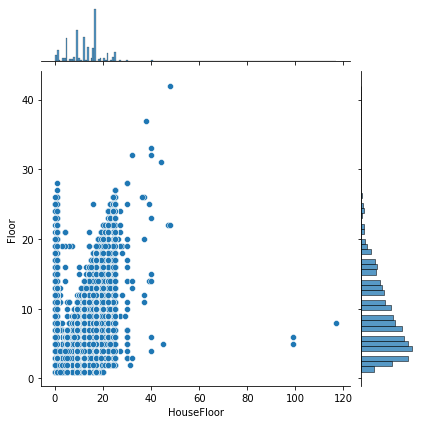

In [12]:
sns.jointplot(train_df['HouseFloor'], train_df['Floor'], kind='scatter', height=6);

# Если этаж дома =0 то замена на 1

# Если этаж квартиры =0 то замена на 1


In [13]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] + 1
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] + 1

train_df.loc[train_df['Floor'] == 0, 'Floor'] = train_df.loc[train_df['Floor'] == 0, 'Floor'] + 1
test_df.loc[test_df['Floor'] == 0, 'Floor'] = test_df.loc[test_df['Floor'] == 0, 'Floor'] + 1

In [14]:
train_df[(train_df['HouseFloor'] > 45)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1674,76,2.000,74.345,41.044,5.000,42,48.000,2016,0.000,1,1,7,1660,39,1786.000,1,5,1,411691.505
6502,20,1.000,126.390,103.637,14.000,22,47.000,2012,0.020,1,1,37,7687,11,176.000,5,5,1,450706.553
10806,5,1.000,51.945,48.710,1.000,6,99.000,1977,0.151,1,1,16,3433,4,2643.000,4,5,1,296127.116
7453,24,3.000,126.621,62.455,12.000,22,48.000,2011,0.112,1,1,50,12238,8,1970.000,2,3,1,179396.521
9300,74,2.000,71.748,74.580,9.000,5,99.000,1977,0.076,1,1,6,1437,3,900.000,0,2,1,243329.913
78,30,2.000,65.774,66.812,1.000,8,117.000,1977,0.000,1,1,22,6398,141,1046.000,3,23,1,207248.371


# Если этаж выше 45, то заменяется на моду

In [15]:
train_df.loc[train_df['HouseFloor'] > 45, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 45, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [16]:
train_df[(train_df['Floor'] > train_df['HouseFloor'])]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.000,80.313,80.313,0.000,14,1.000,1977,0.076,1,1,6,1437,3,900.000,0,2,1,221244.157
10953,27,1.000,53.769,52.408,1.000,5,4.000,1977,0.072,1,1,2,629,1,900.000,0,0,0,140647.566
2119,27,2.000,49.361,31.994,5.000,6,5.000,1983,0.052,1,1,5,1227,0,900.000,0,0,1,117000.381
11935,27,2.000,64.712,63.712,1.000,15,1.000,1977,0.211,1,1,9,1892,0,900.000,0,1,1,127200.027
6641,54,3.000,118.908,118.908,0.000,2,1.000,1977,0.006,1,1,30,5285,0,645.000,6,6,1,571069.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,52,3.000,64.075,47.633,6.000,11,9.000,1983,0.371,1,1,34,7065,1,750.000,2,5,1,226434.880
16159,27,1.000,38.968,37.968,1.000,10,1.000,1977,0.211,1,1,9,1892,0,900.000,0,1,1,95529.569
4145,96,3.000,90.055,47.860,11.000,26,24.000,2005,0.041,1,1,53,14892,4,900.000,1,4,1,441108.911


# Если этаж квартиры > этажа дома, то меняется на mean этажа квартиры

In [17]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = train_df['Floor'].mean()
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor'] = train_df['HouseFloor'].mean()

test_df.loc[(test_df['Floor'] > test_df['HouseFloor']), 'Floor'] = train_df['Floor'].mean()
test_df.loc[(test_df['Floor'] > test_df['HouseFloor']), 'HouseFloor'] = train_df['HouseFloor'].mean()

In [18]:
train_df['HouseFloor'].describe()

count   10000.000
mean       13.809
std         5.294
min         1.000
25%         9.000
50%        13.000
75%        17.000
max        45.000
Name: HouseFloor, dtype: float64

In [19]:
test_df['HouseFloor'].describe()

count   5000.000
mean      13.872
std        5.439
min        1.000
25%        9.000
50%       13.809
75%       17.000
max       40.000
Name: HouseFloor, dtype: float64

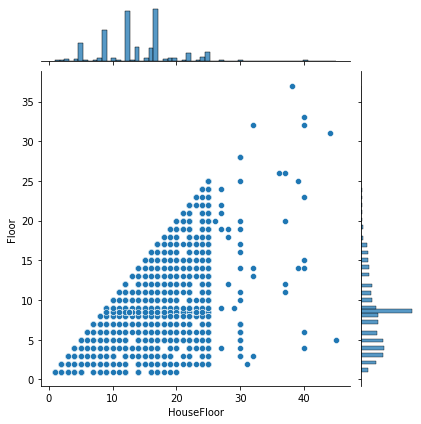

In [20]:
sns.jointplot(train_df['HouseFloor'], train_df['Floor'], kind='scatter', height=6);

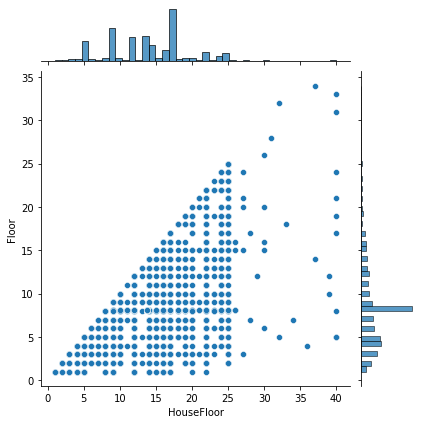

In [21]:
sns.jointplot(test_df['HouseFloor'], test_df['Floor'], kind='scatter', height=6);

In [22]:
train_df['LifeSquare'].describe()

count   10000.000
mean       41.799
std        77.824
min         0.371
25%        25.494
50%        37.041
75%        49.823
max      7480.592
Name: LifeSquare, dtype: float64

In [23]:
test_df['LifeSquare'].describe()

count   5000.000
mean      40.908
std       20.321
min        0.333
25%       25.845
50%       36.936
75%       50.132
max      303.071
Name: LifeSquare, dtype: float64

# Если LifeSquare = 0, меняется на разность общей площади и кухни

In [24]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

# Если общая площадь меньше суммы жилой и кухни, то меняется на mean суммы площадей жилой комнаты и кухни

In [25]:
train_df.loc[(train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare'])), 'Square'] \
                = (train_df['LifeSquare'] + train_df['KitchenSquare']).mean()

test_df.loc[(test_df['Square'] < (test_df['LifeSquare'] + test_df['KitchenSquare'])), 'Square'] \
                = (train_df['LifeSquare'] + train_df['KitchenSquare']).mean()

In [26]:
train_df[train_df['Square'] > 250]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5548,86,5.000,275.645,233.949,26.000,12.000,37.000,2011,0.162,1,0,31,7010,5,4508.000,3,7,1,455264.883
28,9,2.000,604.706,603.706,1.000,17.000,18.000,1977,0.162,1,1,25,5648,1,30.000,2,4,1,187717.243


# Общая площадь больше 250 меняется на mean Общей площади

In [27]:
train_df.loc[(train_df['Square'] > 250), 'Square'] = train_df['Square'].mean()

# Кухня равная 0 или больше 200, меняется на mean кухни

In [28]:
train_df.loc[(train_df['KitchenSquare'] == 0), 'KitchenSquare'] = train_df['KitchenSquare'].mean()
train_df.loc[(train_df['KitchenSquare'] > 200), 'KitchenSquare'] = train_df['KitchenSquare'].mean()

test_df.loc[(test_df['KitchenSquare'] == 0), 'KitchenSquare'] = train_df['KitchenSquare'].mean()
test_df.loc[(test_df['KitchenSquare'] > 200), 'KitchenSquare'] = train_df['KitchenSquare'].mean()

# Если площадь кухни больше общей, то меняется на разность общей площади и жилой

In [29]:
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare'] \
            = (train_df['Square'] - train_df['LifeSquare']).mean()

test_df.loc[(test_df['KitchenSquare'] > test_df['Square']), 'KitchenSquare'] \
            = (train_df['Square'] - train_df['LifeSquare']).mean()

# Если жилая больше общей, то меняется на среднее разности общей площади и кухни. Если площадь общей больше 300 то меняется на среднее


In [30]:
train_df.loc[(train_df['LifeSquare'] > 300), 'LifeSquare'] = train_df['LifeSquare'].mean()
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'LifeSquare'] \
                = (train_df['Square'] - train_df['KitchenSquare']).mean()

In [31]:
test_df.loc[(test_df['LifeSquare'] > 300), 'LifeSquare'] = train_df['LifeSquare'].mean()
test_df.loc[(test_df['LifeSquare'] > test_df['Square']), 'LifeSquare'] \
                = (train_df['Square'] - train_df['KitchenSquare']).mean()

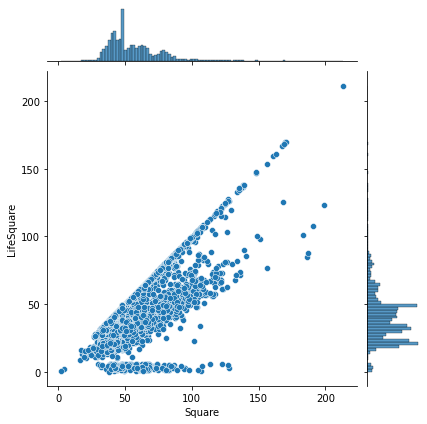

In [32]:
sns.jointplot(train_df['Square'], train_df['LifeSquare'], kind='scatter', height=6);

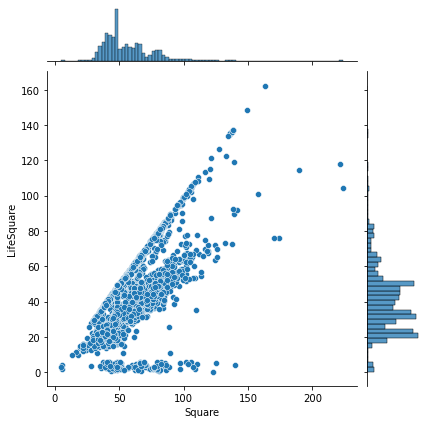

In [33]:
sns.jointplot(test_df['Square'], test_df['LifeSquare'], kind='scatter', height=6);

# Нулевые комнаты меняются на 1, кол-во комнат больше 6 меняется на среднее

In [34]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = train_df.loc[train_df['Rooms'] == 0, 'Rooms'] + 1
test_df.loc[test_df['Rooms'] == 0, 'Rooms'] = test_df.loc[test_df['Rooms'] == 0, 'Rooms'] + 1

train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].mean()
test_df.loc[test_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].mean()

# Года больше 2020 меняются на 2020

In [35]:
train_df[(train_df['HouseYear'] > 2020)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.000,37.265,20.240,9.000,9.000,12.000,20052011,0.136,1,1,30,6141,10,262.000,3,6,1,254084.534
11607,147,2.000,44.792,28.360,5.000,4.000,9.000,4968,0.320,1,1,25,4756,16,2857.000,5,8,1,243028.603


In [36]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

# Новые признаки

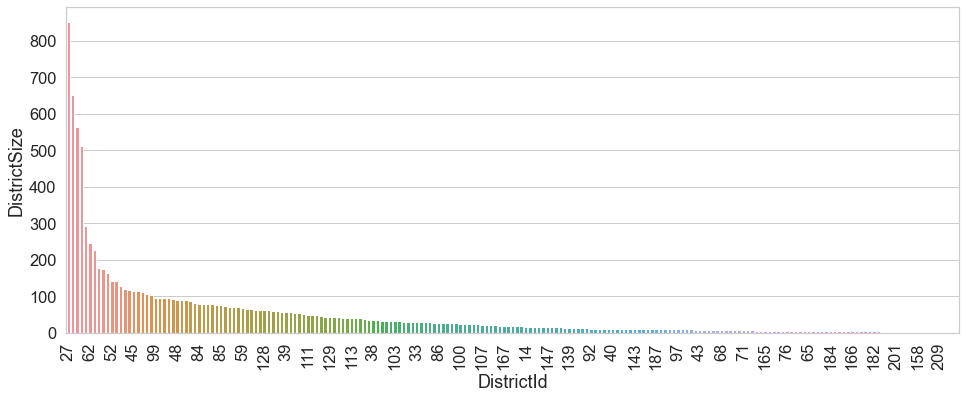

In [37]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [38]:
district_size.loc[district_size['DistrictSize'] > 100, :]

districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)

In [39]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [40]:
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)

In [41]:
train_df['RoomSquare'] = train_df['Square'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['Square'] / test_df['Rooms']

In [42]:
train_df['Rooms_Per_Floor'] = train_df['Rooms'] / train_df['Floor']
test_df['Rooms_Per_Floor'] = test_df['Rooms'] / test_df['Floor']

In [43]:
train_df['RoomSquare_LifeOnly'] = train_df['LifeSquare'] / train_df['Rooms']
test_df['RoomSquare_LifeOnly'] = test_df['LifeSquare'] / test_df['Rooms']

In [44]:
feature_num_names = train_df.drop(['Ecology_1','Healthcare_1','Price'], axis=1).select_dtypes(include='float64').columns.tolist()
feature_num_names


['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'RoomSquare',
 'Rooms_Per_Floor',
 'RoomSquare_LifeOnly']

array([[<AxesSubplot:title={'center':'Rooms_log'}>,
        <AxesSubplot:title={'center':'Square_log'}>,
        <AxesSubplot:title={'center':'LifeSquare_log'}>],
       [<AxesSubplot:title={'center':'KitchenSquare_log'}>,
        <AxesSubplot:title={'center':'Floor_log'}>,
        <AxesSubplot:title={'center':'HouseFloor_log'}>],
       [<AxesSubplot:title={'center':'RoomSquare_log'}>,
        <AxesSubplot:title={'center':'Rooms_Per_Floor_log'}>,
        <AxesSubplot:title={'center':'RoomSquare_LifeOnly_log'}>]],
      dtype=object)

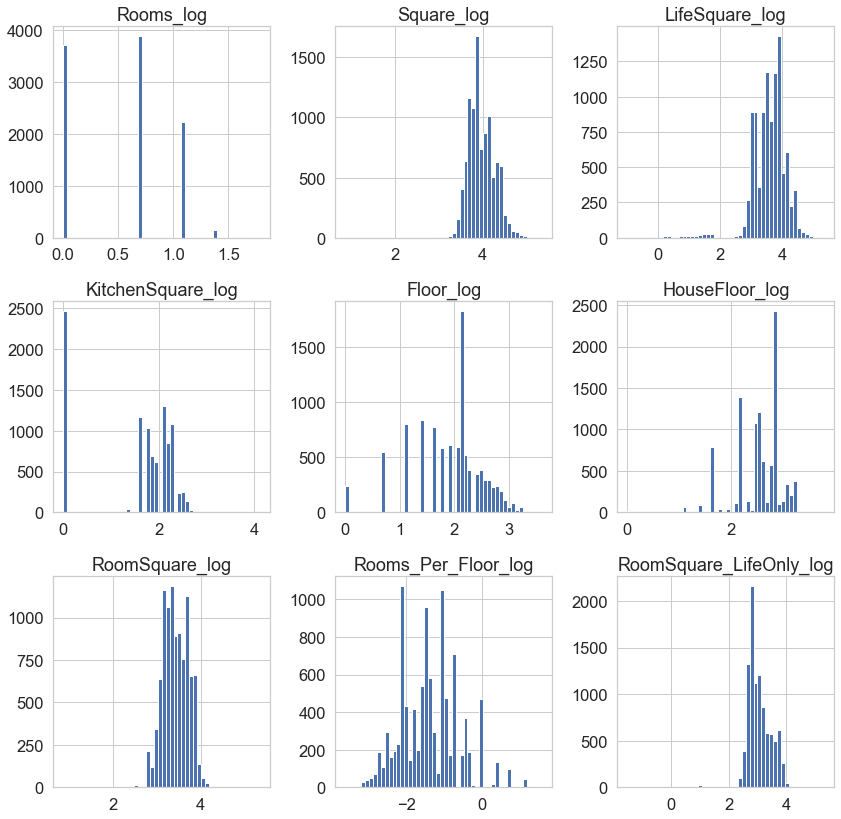

In [45]:
feature_skewed_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                        'Floor', 'HouseFloor', 'RoomSquare',
                        'Rooms_Per_Floor', 'RoomSquare_LifeOnly']
feature_log_names = []
for f in feature_skewed_names:
    train_df[f + '_log'] = np.log(train_df[f])
    feature_log_names.append(f + '_log')

train_df[feature_log_names].hist(figsize=(14,14), bins=50, grid=True)

array([[<AxesSubplot:title={'center':'Rooms_log'}>,
        <AxesSubplot:title={'center':'Square_log'}>,
        <AxesSubplot:title={'center':'LifeSquare_log'}>],
       [<AxesSubplot:title={'center':'KitchenSquare_log'}>,
        <AxesSubplot:title={'center':'Floor_log'}>,
        <AxesSubplot:title={'center':'HouseFloor_log'}>],
       [<AxesSubplot:title={'center':'RoomSquare_log'}>,
        <AxesSubplot:title={'center':'Rooms_Per_Floor_log'}>,
        <AxesSubplot:title={'center':'RoomSquare_LifeOnly_log'}>]],
      dtype=object)

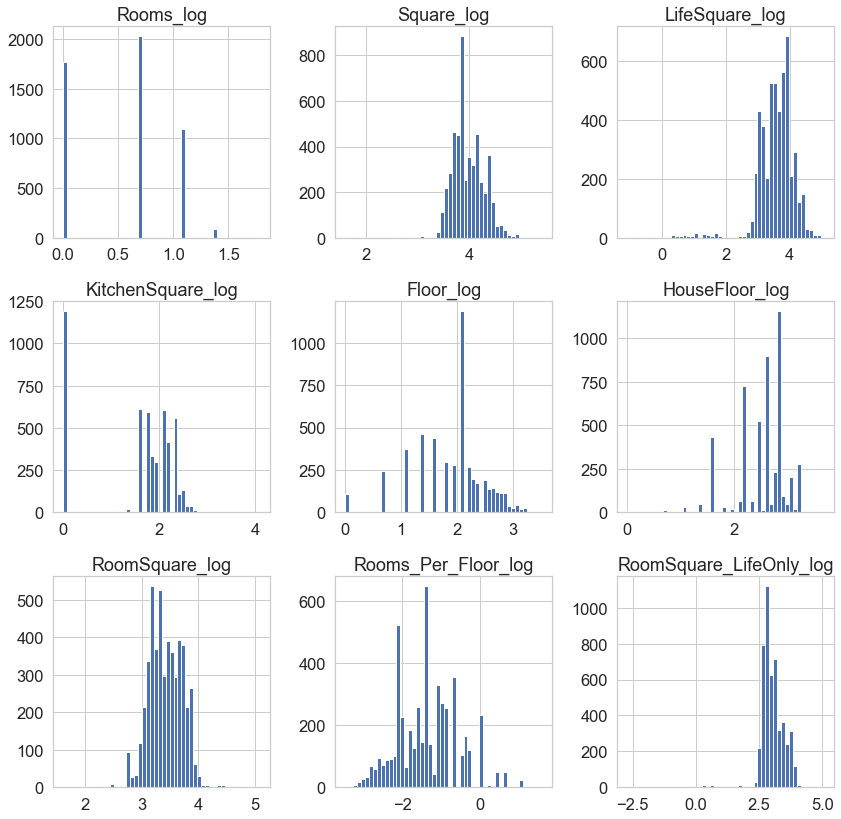

In [46]:
feature_skewed_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                        'Floor', 'HouseFloor', 'RoomSquare',
                        'Rooms_Per_Floor', 'RoomSquare_LifeOnly']
feature_log_names = []
for f in feature_skewed_names:
    test_df[f + '_log'] = np.log(test_df[f])
    feature_log_names.append(f + '_log')

test_df[feature_log_names].hist(figsize=(14,14), bins=50, grid=True)

In [47]:
train_df.to_csv('train_prepared.csv')
test_df.to_csv('test_prepared.csv')

In [48]:
feature_names = train_df.drop(['Price'], axis=1).columns

feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'DistrictSize',
 'RoomSquare',
 'Rooms_Per_Floor',
 'RoomSquare_LifeOnly',
 'Rooms_log',
 'Square_log',
 'LifeSquare_log',
 'KitchenSquare_log',
 'Floor_log',
 'HouseFloor_log',
 'RoomSquare_log',
 'Rooms_Per_Floor_log',
 'RoomSquare_LifeOnly_log']

# Подбор признаков

In [49]:
feature_names_full = [feature for feature in feature_names if feature not in ['Price']]
len(feature_names_full)

31

In [50]:
target_name = ['Price']
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
# 'Ecology_2',
# 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
# 'Shops_2',
# 'Price',
 'DistrictSize',
 'RoomSquare',
 'Rooms_Per_Floor',
 'Rooms_log',
 'Square_log',
 'LifeSquare_log',
 'KitchenSquare_log',
 'Floor_log',
 'HouseFloor_log',
 'RoomSquare_log',
 #'Rooms_Per_Floor_log',
 'RoomSquare_LifeOnly',
 'RoomSquare_LifeOnly_log'
                ]

In [51]:
X = train_df[feature_names]
y = train_df[target_name]

In [52]:
len(feature_names) 

27

In [53]:
catboost_model = CatBoostRegressor(silent=True, learning_rate=0.05, eval_metric='R2', depth=8)

catboost_model.fit(X, y)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(catboost_model, X, y, scoring='r2', cv=kf)

print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.74765


In [54]:
catboost_model.fit(X, y)
importances = catboost_model.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

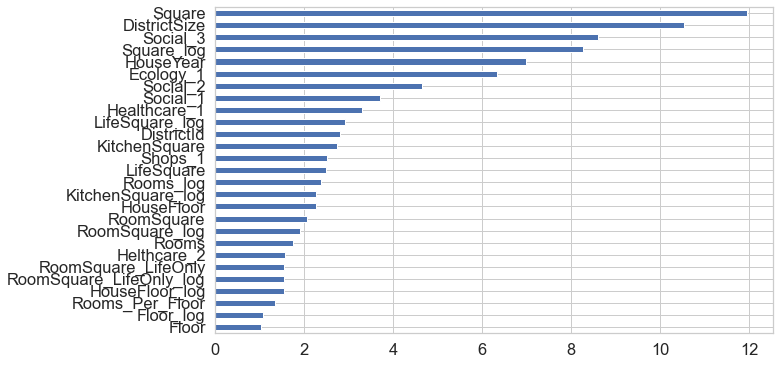

In [55]:
feat_importances.plot(kind='barh', figsize=(10, 6)); 

In [56]:
params = {'learning_rate' : [0.03, 0.1], 'depth' : [4, 6, 10], 'l2_leaf_reg' : [1, 3, 5, 7, 9]}

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
catboost_grid = GridSearchCV(catboost_model, params, scoring='r2', n_jobs = -1)
catboost_grid.fit(X, y)
print(catboost_grid.best_params_)
print('R2 на train: {:.5f}'.format(catboost_grid.best_score_))

{'depth': 10, 'l2_leaf_reg': 5, 'learning_rate': 0.03}
R2 на train: 0.74495


In [58]:
catboost_best = CatBoostRegressor(silent=True, learning_rate=0.05, eval_metric='R2', depth=8)
catboost_best.fit(X, y)
y_pred = catboost_best.predict(test_df[feature_names])
y_pred

array([150457.41816785, 224396.45366974, 257738.96639681, ...,
       323766.02478944, 189721.06203858, 177165.95751772])

In [59]:
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,150457.418
1,15856,224396.454
2,5480,257738.966
3,15664,347153.077
4,14275,137296.177


In [60]:
preds.to_csv('SagitovaD_prediction.csv', index=False)